In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
#np.random.seed(123)

# viz
import matplotlib.pyplot as plt

# notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 1000)

## Sample Prep

In [3]:
samples = pd.read_csv('../data/TCGA/rna-seq_adeno/meta/gdc_sample_sheet.2020-01-27.tsv', sep="\t")
# get file type
samples['data'] = [val[1] for i,val in samples['File Name'].str.split(".").items()]
samples['Project ID'].value_counts()

TCGA-LUSC    301
TCGA-LUAD    287
CPTAC-3      209
Name: Project ID, dtype: int64

Samples with RNAseq adjacent normal tissue

In [4]:
samples['Sample Type'].value_counts()

Primary Tumor                               558
Solid Tissue Normal                         206
Primary Tumor, Primary Tumor                 29
Solid Tissue Normal, Solid Tissue Normal      4
Name: Sample Type, dtype: int64

In [5]:
samples.loc[samples['Sample Type']=='Primary Tumor, Primary Tumor', 'Sample Type'] = 'Primary Tumor'
samples.loc[samples['Sample Type']=='Solid Tissue Normal, Solid Tissue Normal', 'Sample Type'] = 'Solid Tissue Normal'

In [6]:
samples['Sample Type'].value_counts()

Primary Tumor          587
Solid Tissue Normal    210
Name: Sample Type, dtype: int64

In [7]:
# all cases with adjacent normal tissue
cases = samples[samples['Sample Type']=='Solid Tissue Normal']['Case ID']

In [8]:
# disparity in cases
samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Primary Tumor') 
        & (samples['data']=='FPKM')]['Case ID'].nunique()
samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Solid Tissue Normal') 
        & (samples['data']=='FPKM')]['Case ID'].nunique()

176

210

In [9]:
# divide, join, subset
case_tumor = samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Primary Tumor') & 
                     (samples['data']=='FPKM')]
case_norm = samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Solid Tissue Normal') & 
                    (samples['data']=='FPKM')]
cases = pd.merge(case_tumor['Case ID'], case_norm['Case ID'])['Case ID']
cases.shape

(187,)

In [10]:
case_tumor = case_tumor[case_tumor['Case ID'].isin(cases)]
case_norm = case_norm[case_norm['Case ID'].isin(cases)]
# random shuffle so test dataset loader has random order
cases = pd.concat([case_tumor, case_norm]).sample(frac=1)

In [11]:
case_tumor.shape
case_norm.shape
cases.shape

(187, 9)

(176, 9)

(363, 9)

## Map Ensembl genes to Proteins

In [12]:
id_map = pd.read_csv("/srv/home/wconnell/keiser/data/uniprot_mapping_ids/map_ensembl_uniprot.csv")
reviewed_proteins = pd.read_csv("/srv/home/wconnell/keiser/data/uniprot_mapping_ids/TCGA_rnaseq_uniprot_features.tab.gz", sep="\t")
proteins = pd.merge(id_map, reviewed_proteins, left_on='UNIPROT_ID', right_on='Entry name')
proteins['hgnc'] = [gene.split(";")[0] for gene in proteins['Gene names  (primary )']]
proteins.shape

(18842, 22)

## Dataset Prep

Need to ensure test set has health/diseased samples matched for each case

In [13]:
def train_test_split_case(samples, cases, test_size=0.25):
    """
    Splits dataframe into random train and test sets for Siamese network evaluation.
    
    The test set will only contain cases with a single pair of matched samples.
    The train set will contain all others, even cases that have > 2 samples, irrespective if they are exactly matched.
    
    """
    # total test size, round to even number for subsetting test
    n_test = int(len(samples) * test_size)
    if n_test % 2 != 0: n_test = n_test - 1
    # subset samples with a single matched pair
    ids = samples.groupby([cases]).size()
    assert (ids > 1).all(), "Some samples do not have at least a single matched pair."
    ids = ids[ids == 2].index.values
    test_ids = np.random.choice(ids, size=int(n_test/2), replace=False)
    return samples[~samples[cases].isin(test_ids)].reset_index(drop=True), samples[samples[cases].isin(test_ids)].reset_index(drop=True)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target = 'Sample Type'
cases[target] = cases[target].astype('category').cat.reorder_categories(['Solid Tissue Normal', 'Primary Tumor'])

train, test = train_test_split_case(samples=cases, cases='Case ID', test_size=0.25)
train[target].value_counts()
test[target].value_counts()

Primary Tumor          142
Solid Tissue Normal    131
Name: Sample Type, dtype: int64

Primary Tumor          45
Solid Tissue Normal    45
Name: Sample Type, dtype: int64

In [15]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
#torch.manual_seed(123)

from trainer import fit
import visualization as vis
import numpy as np
cuda = torch.cuda.is_available()
print("Cuda is available: {}".format(cuda))

classes = {key:val for val,key in enumerate(train[target].cat.categories.values)}
classes

Cuda is available: True


{'Solid Tissue Normal': 0, 'Primary Tumor': 1}

In [16]:
from tcga_datasets import TCGA, SiameseTCGA
root_dir = "../data/TCGA/rna-seq_adeno/"
batch_size = 1

train_dataset = TCGA(root_dir, samples=train, train=True, target=target, log=True)
test_dataset = TCGA(root_dir, samples=test, train=False, target=target, log=True)

scaler = StandardScaler()
train_dataset.data = pd.DataFrame(scaler.fit_transform(train_dataset.data),
                                  index=train_dataset.data.index,
                                  columns=train_dataset.data.columns)
test_dataset.data = pd.DataFrame(scaler.transform(test_dataset.data),
                                 index=test_dataset.data.index,
                                 columns=test_dataset.data.columns)

kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {'num_workers': 10}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

#### Subset gene data to annotated proteins

In [17]:
assert np.array_equal(train_dataset.data.columns, test_dataset.data.columns)
parsed_cols = [ens[0] for ens in train_dataset.data.columns.str.split(".")]

train_dataset.data.columns, test_dataset.data.columns = parsed_cols, parsed_cols
protein_overlap_idx = np.isin(train_dataset.data.columns, proteins['ENSEMBL_ID'].values)

train_dataset.data = train_dataset.data.loc[:,protein_overlap_idx]
test_dataset.data = test_dataset.data.loc[:,protein_overlap_idx]

## Siamese Network

In [18]:
# Step 1 set up dataloader
root_dir = "../data/TCGA"
siamese_train_dataset = SiameseTCGA(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseTCGA(test_dataset)
batch_size = 8
kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from tcga_networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss
from metrics import AccumulatedAccuracyMetric

# Step 2
n_samples, n_features = siamese_train_dataset.data.shape
embedding_net = EmbeddingNet(n_features)
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10
# print training metrics every log_interval * batch_size
log_interval = 30

SiameseNet(
  (embedding_net): EmbeddingNet(
    (fc): Sequential(
      (linear1): Linear(in_features=18812, out_features=2000, bias=True)
      (relu1): PReLU(num_parameters=1)
      (linear2): Linear(in_features=2000, out_features=500, bias=True)
      (relu2): PReLU(num_parameters=1)
      (linear3): Linear(in_features=500, out_features=250, bias=True)
      (relu3): PReLU(num_parameters=1)
      (linear4): Linear(in_features=250, out_features=100, bias=True)
      (relu4): PReLU(num_parameters=1)
      (linear5): Linear(in_features=100, out_features=50, bias=True)
      (relu5): PReLU(num_parameters=1)
      (linear6): Linear(in_features=50, out_features=10, bias=True)
      (relu6): PReLU(num_parameters=1)
      (linear7): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [19]:
train_loss, val_loss = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, 
    n_epochs, cuda, log_interval)

Train: [0/273 (0%)]	Loss: 0.311630
Train: [240/273 (86%)]	Loss: 0.075428
Epoch: 1/10. Train set: Average loss: 0.0749
Epoch: 1/10. Validation set: Average loss: 0.0396
Train: [0/273 (0%)]	Loss: 0.004492
Train: [240/273 (86%)]	Loss: 0.017471
Epoch: 2/10. Train set: Average loss: 0.0155
Epoch: 2/10. Validation set: Average loss: 0.0078
Train: [0/273 (0%)]	Loss: 0.001701
Train: [240/273 (86%)]	Loss: 0.009214
Epoch: 3/10. Train set: Average loss: 0.0084
Epoch: 3/10. Validation set: Average loss: 0.0065
Train: [0/273 (0%)]	Loss: 0.005134
Train: [240/273 (86%)]	Loss: 0.008385
Epoch: 4/10. Train set: Average loss: 0.0076
Epoch: 4/10. Validation set: Average loss: 0.0240
Train: [0/273 (0%)]	Loss: 0.000855
Train: [240/273 (86%)]	Loss: 0.003788
Epoch: 5/10. Train set: Average loss: 0.0059
Epoch: 5/10. Validation set: Average loss: 0.0280
Train: [0/273 (0%)]	Loss: 0.012062
Train: [240/273 (86%)]	Loss: 0.005398
Epoch: 6/10. Train set: Average loss: 0.0070
Epoch: 6/10. Validation set: Average loss:

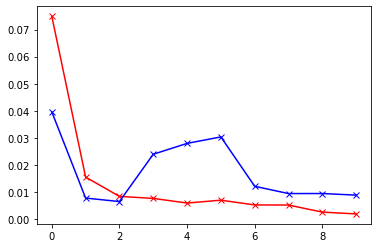

In [20]:
plt.plot(range(0, n_epochs), train_loss, 'rx-')
plt.plot(range(0, n_epochs), val_loss, 'bx-')

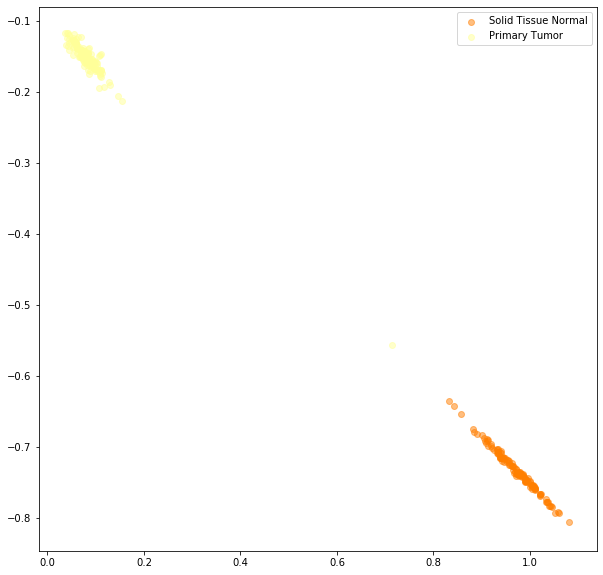

In [21]:
train_embeddings_cl, train_labels_cl = vis.extract_embeddings(train_loader, model)
vis.plot_embeddings(train_embeddings_cl, train_labels_cl, siamese_train_dataset.labels_dict)

Frusturatingly the test_loader(shuffl=False) only works to load here because it has been specified for 1 sample at a time. The data order is the same as siamese_test_loader(shuffle=False).

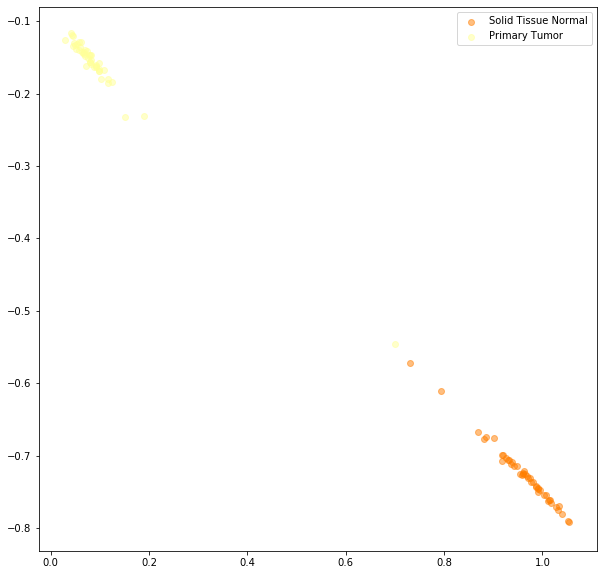

In [22]:
val_embeddings_baseline, val_labels_baseline = vis.extract_embeddings(test_loader, model)
vis.plot_embeddings(val_embeddings_baseline, val_labels_baseline, siamese_test_dataset.labels_dict)

#### Write out test set for DE analysis

In [23]:
siamese_test_dataset.samples['label'] = siamese_test_dataset.labels
siamese_test_dataset.samples.to_pickle("../data/tmp/test_dataset_meta.pkl.gz")
siamese_test_dataset.data.to_pickle("../data/tmp/test_dataset.pkl.gz")

## Integrated Gradients
Test completeness axiom through comparison of different baselines

"Integrated gradients satisfy an
axiom called completeness that the attributions add up to
the difference between the output of F at the input x and
the baseline x'."

In [24]:
import copy
from captum.attr import LayerActivation
from captum.attr import IntegratedGradients

The model tested on random pairs but now

Need to match raw data sample pairs of the same individual.

In [25]:
def matched_pairs(SiameseTCGA, exp, ctrl):
    """
    Returns raw data from pairs of samples by case in test set.
    """
    gb = SiameseTCGA.samples.groupby('Sample Type')
    gb_splits = [gb.get_group(sample_type).sort_values(by='Case ID') for sample_type in gb.groups]

    assert np.array_equal(gb_splits[0]['Case ID'].values, gb_splits[1]['Case ID'].values), "Order of matched sample pairs not in sync."
    
    cases = gb_splits[0]['Case ID'].values
    
    ctrl_data = Variable(SiameseTCGA.test_data[gb.groups[ctrl]], requires_grad=True)
    exp_data = Variable(SiameseTCGA.test_data[gb.groups[exp]], requires_grad=True)
    
    return ctrl_data, exp_data, cases

# IG with Control vector

In [26]:
ctrl_data, exp_data, cases = matched_pairs(siamese_test_dataset, exp='Primary Tumor', ctrl='Solid Tissue Normal')

In [27]:
from torch.nn import PairwiseDistance
pdist = PairwiseDistance(p=2)
pdist

PairwiseDistance()

In [28]:
ig = IntegratedGradients(model.get_dist)

In [29]:
torch.cuda.empty_cache()

## Healthy as baseline

In [30]:
attr, delta = ig.attribute(exp_data.cuda(), ctrl_data.cuda(), target=None, n_steps=50, return_convergence_delta=True,
                          additional_forward_args=(ctrl_data.cuda(), pdist))
attr = attr.cpu().detach().numpy()
delta

tensor([ 0.0131, -0.0025, -0.0013, -0.0111,  0.0106,  0.0019,  0.0028,  0.0091,
         0.0019, -0.0007,  0.0165,  0.0021,  0.0117, -0.0006, -0.0020, -0.0212,
        -0.0053, -0.0029,  0.0075, -0.0035, -0.0062,  0.0070, -0.0138, -0.0014,
        -0.0003,  0.0101,  0.0003, -0.0058, -0.0043,  0.0083,  0.0098, -0.0034,
         0.0241,  0.0028,  0.0010, -0.0135, -0.0068, -0.0180,  0.0111,  0.0148,
         0.0038, -0.0020, -0.0032, -0.0021, -0.0129], device='cuda:0')

In [31]:
attr.shape

(45, 18812)

## Average Protein Feature Attributions

In [32]:
proteins['ENSEMBL_ID'].values.shape
attr.shape[1]

(18842,)

18812

In [33]:
feat_imp = pd.DataFrame(data=attr.mean(axis=0), index=siamese_test_dataset.data.columns, columns=['Attribution'])
feat_imp.shape
feat_imp = pd.merge(feat_imp, proteins.drop_duplicates(subset='ENSEMBL_ID'), left_index=True, right_on='ENSEMBL_ID', how='left').sort_values(by='Attribution', ascending=False).reset_index(drop=True)
feat_imp.shape

(18812, 1)

(18812, 23)

In [34]:
feat_imp.to_pickle("../data/tmp/attr_avg.pkl.gz")

### Now go to /srv/home/wconnell/github/diffxpy/notebook/2020.02.05_test_DE_analysis and run

In [35]:
feat_imp[['Attribution', 'hgnc', 'Protein names', 'Gene ontology (biological process)', 'Gene ontology (molecular function)']]

,Attribution,hgnc,Protein names,Gene ontology (biological process),Gene ontology (molecular function)
0,0.000801,SPANXA1,Sperm protein associated with the nucleus on t...,spermatogenesis [GO:0007283],NaN
1,0.000611,COL10A1,Collagen alpha-1(X) chain,extracellular matrix organization [GO:0030198]...,extracellular matrix structural constituent [G...
2,0.000558,GKN2,Gastrokine-2 (Blottin) (Down-regulated in gast...,response to bacterium [GO:0009617],NaN
3,0.000536,LAMP3,Lysosome-associated membrane glycoprotein 3 (L...,adaptive immune response [GO:0002250]; establi...,NaN
4,0.000535,PID1,"PTB-containing, cubilin and LRP1-interacting p...",cellular response to cytokine stimulus [GO:007...,NaN
...,...,...,...,...,...
18807,-0.000222,OR51G2,Olfactory receptor 51G2 (Olfactory receptor OR...,NaN,G protein-coupled receptor activity [GO:000493...
18808,-0.000241,DAZL,Deleted in azoospermia-like (DAZ homolog) (DAZ...,3'-UTR-mediated mRNA stabilization [GO:0070935...,identical protein binding [GO:0042802]; mRNA 3...
18809,-0.000258,DUXA,Double homeobox protein A,NaN,DNA binding [GO:0003677]; DNA-binding transcri...
18810,-0.000318,MAS1L,Mas-related G-protein coupled receptor MRG (MA...,G protein-coupled receptor signaling pathway [...,G protein-coupled receptor activity [GO:0004930]


## Individual Protein Feature Attributions

In [36]:
feat_ind_imp = pd.DataFrame(data=attr,
                            columns=siamese_test_dataset.data.columns,
                            index=cases)

In [37]:
proteins_ = proteins.drop_duplicates(subset='ENSEMBL_ID')

In [38]:
gene_dict = pd.Series(index=proteins_['ENSEMBL_ID'].values, data=proteins_['hgnc'].values).to_dict()

In [39]:
feat_ind_imp = feat_ind_imp.rename(columns=gene_dict)

In [40]:
feat_ind_imp.head()

,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,NIPAL3,LAS1L,ENPP4,SEMA3F,CFTR,ANKIB1,CYP51A1,KRIT1,RAD52,BAD,LAP3,CD99,HS3ST1,AOC1,WNT16,HECW1,MAD1L1,LASP1,SNX11,TMEM176A,M6PR,KLHL13,CYP26B1,ICA1,DBNDD1,CASP10,CFLAR,TFPI,NDUFAF7,RBM5,MTMR7,SLC7A2,ARF5,SARM1,POLDIP2,PLXND1,AK2,CD38,FKBP4,KDM1A,RBM6,CAMKK1,RECQL,VPS50,HSPB6,ARHGAP33,NDUFAB1,PDK4,SLC22A16,ZMYND10,ABCB5,ARX,SLC25A13,ST7,CDC27,SLC4A1,CALCR,HCCS,DVL2,PRSS22,UPF1,SKAP2,SLC25A5,MCUB,HOXA11,POLR2J,DHX33,MEOX1,THSD7A,LIG3,RPAP3,ACSM3,REXO5,CIAPIN1,SPPL2B,FAM214B,COPZ2,PRKAR2B,MSL3,CREBBP,TSPOAP1,MPO,PON1,GCFC2,WDR54,CROT,ABCB4,KMT2E,RHBDD2,SOX8,IBTK,ZNF195,MYCBP2,FBXL3,ITGAL,PDK2,ITGA3,ZFX,LAMP2,ITGA2B,ASB4,GDE1,REX1BD,CRLF1,OSBPL7,TMEM98,YBX2,KRT33A,MAP3K14,ABCC8,CACNG3,TMEM132A,AP2B1,TAC1,ZNF263,CX3CL1,SPATA20,CACNA1G,TNFRSF12A,DLX6,MAP3K9,RALA,BAIAP2L1,KDM7A,ETV1,AGK,ALDH3B1,TTC22,PHTF2,CCL26,FARP2,USH1C,GGCT,DBF4,TBXA2R,IFRD1,LGALS14,COX10,GTF2IRD1,PAF1,VPS41,ARHGAP44,ELAC2,SCIN,ARSD,PNPLA4,MYH13,ADIPOR2,CDKL3,UPP2,PRSS21,MARK4,PROM1,CCDC124,CEACAM21,PAFAH1B1,NOS2,DNAH9,KIAA0100,SLC13A2,GAS7,TRAPPC6A,MATK,CEACAM7,CD79B,SCN4A,ST7L,TKTL1,PAX6,RPUSD1,RHBDF1,LUC7L,CACNA2D2,BAIAP3,TSR3,PIGQ,CRAMP1,TEAD3,SELE,DNAJC11,FMO3,MYLIP,NOX1,E2F2,PSMB1,SYN1,JARID2,CDKL5,CAMK1G,CDK11A,NADK,TFAP2B,TFAP2D,DLEC1,CYTH3,ADAM22,SYPL1,CYB561,SPAG9,CELSR3,AASS,PLEKHG6,SS18L2,MPND,MGST1,CRY1,PGLYRP1,NFIX,ST3GAL1,MMP25,IL32,PKD1,MAPK8IP2,MED24,RHOBTB2,HEATR5B,SEC62,RPS20,CSDE1,UBE3C,REV3L,TENM1,PAX7,MASP2,IYD,FAM76A,TRAF3IP3,POMT2,VTA1,MLXIPL,BAZ1B,RANBP9,ETV7,SPRTN,EEF1AKNMT,DYRK4,ZNF207,UQCRC1,STARD3NL,CD9,HHATL,NCAPD2,IFFO1,GIPR,PHF7,SEMA3G,NISCH,FUZ,SLC6A13,IDS,PRSS3,ZNF200,CD4,LRRC23,BTK,HFE,SCMH1,FYN,HIVEP2,FMO1,ELOA,LYPLA2,CLCN6,MRC2,SLC6A7,TSPAN9,BTBD7,APBA3,MKS1,ABHD5,ANOS1,AKAP8L,MBTD1,UTP18,RNF216,TTC19,PTBP1,DPF1,SYT7,LARS2,PIK3C2A,PLAUR,ANLN,WIZ,RABGAP1,DCN,QPCTL,PPP5C,CEP68,ZBTB32,TYROBP,TMEM159,GABRA3,BRCA1,ERCC1,CD22,SEMA3B,MBTPS2,PRICKLE3,LTF,EXTL3,NR1H4,ELOVL5,ALOX5,KDM5D,CALCOCO1,UBR7,EHD3,PSMC4,MAN2B2,SLC7A14,CLDN11,SLC25A39,MVP,NUB1,PGM3,RWDD2A,CLK1,POLR3B,ANGEL1,RNF14,DNASE1L1,DDX11,HEBP1,GPRC5A,MAMLD1,CD6,TACC3,UFL1,POLA2,ZC3H3,CAPN1,ACPP,MDH1,SLC30A9,MTMR11,COX15,CCDC88C,YAF2,ZMYND11,WAS,DPEP1,BID,MATR3,NPC1L1,XYLT2,RGPD5,STMN4,NUDCD3,ISL1,CHDH,IL20RA,CLCA1,CLCA4,GLT8D1,ATP2C1,IGF1,SLC38A5,RALBP1,RUFY3,CNTN1,SLC11A1,WWTR1,AGPS,CXorf56,ATP1A2,TTC27,ZNF582,VSIG2,PHLDB1,MARCO,CYP24A1,PRDM11,SYT13,SNAI2,CD74,HGF,ZRANB1,NCDN,ADGRA2,ZFP64,MNAT1,SAMD4A,RUNX3,MRE11,PLEKHB1,SERPINB1,CYP3A43,SLC7A9,SPAST,NRXN3,OSBPL5,AQR,CPS1,C8B,FHL1,RTF2,GABRA1,NLRP2,SLC45A4,RNF10,ZNF839,ZDHHC6,GRAMD1B,RNH1,NDUFS1,RB1CC1,ERP44,ALAS1,BIRC3,AKAP11,GLRX2,SNAPC1,DERA,STRAP,ABCC2,DEF6,PLEKHO1,GCLM,UBR2,EHD2,DEPDC1,CCDC28A,RRAGD,HSF2,PHF20,HSD17B6,NR1H3,TYMP,NCAPH2,TOMM34,SEC63,KPNA6,VIM,FAS,RNASET2,CD44,KCNG1,AGPAT4,SLAMF7,BTN3A1,MIPEP,PRKCH,INSRR,IFNGR1,B4GALT7,SH2D2A,VRK2,TNFRSF1B,VEZT,POU2F2,BRD9,SNX1,TBPL1,ARNTL2,BCLAF1,SLC39A9,ANK1,IBSP,TFB1M,RABEP1,HMGB3,NUP160,BAK1,MUSK,IKZF2,GRN,FAM13B,ARHGAP31,CENPQ,SARS,RANBP3,ARID4A,EIPR1,PNPLA6,IFT88,ALG1,ZCCHC8,ABCF2,CHPF2,LRRC7,FUT8,UBA6,GAB2,ATP6V0A1,PIAS1,SLC4A7,APBA2,MAP2K3,EFCAB1,...,UGT1A10,IGKV2D-28,SERPINB10,HLA-DMB,IGKV1D-43,DECR2,GNG10,CNTF,CCDC169,RTL5,IGKV1D-17,AP5Z1,ZNF709,STRC,RBMY1B,ERVW-1,EIF4EBP3,PRAMEF4,PSG11,UGT1A3,PSG4,MRPL33,MICAL3,PCDHAC2,IGKV2-30,STON1,IGKV2D-29,PRAF2,VSIG8,IGKV1-12,STMP1,KCTD7,EFNA4,TICAM2,C4orf48,IGKV1-5,NAA80,AMY2A,KRTAP10-11,TNFRSF6B,WFDC6,UPK3B,SMIM34A,IL10RB,CFB,ZNF487,WDR92,NME2,PLA2G4B,LEFTY1,CFAP57,NPIPB5,TTC4,OR5V1,TMEM35B,KIR2DL3,JMJD7,APOBEC3D,OR2A7,TUBA4B,MRPS6,ZNF512,GSTA1,RTL9,ACY1,NFS1,MT1HL1,KRTAP19-3,DDOST,TMEM199,LCE3C,GSTA2,SPRR2F,IGKV2-28,UGT1A7,P2RY11,TMEM141,TMEM225B,GMCL2,IFITM10,DBNDD2,LY6G6D,KRTAP19-7,RBMY1D,ETV5,KRTAP5-7,CFHR1,IGKV3-15,RBM12,UGT1A4,ERVFRD-1,LILRA6,SCARF2,APOBEC3C,KRTAP4-2,IGKV1-27,RAD21L1,CCDC13,ASPRV1,OR2AE1,KRTAP20-1,UBE2V1,CTAGE8,PTCHD4,C4A,HBB,CRYBB2,N4BP2L2,ZNF585B,CEBPA,H2AFJ,UBAP1L,PGAM5,ZCCHC3,SPTY2D1OS,TWF2,MARS2,USP51,BCKDHA,INSL3,MARCOL,ADH1C,APELA,

In [41]:
feat_ind_imp.to_pickle("../data/tmp/attr_ind.pkl.gz")